# Bead Analyser

Here we analyse the bead phantom.

We answer the questions, 
* how does the bead width vary with position?
* how does the bead with change with f-number?
### Given the positions of the beads

### We fit beads to a Gaussian

The Gaussian function we are using is given by 

$$f(x) = A \exp\bigg(\frac{(x-\mu)^2}{2 \sigma^2}\bigg)$$

The full-width at half-maximum of the Gaussian is 
$$\text{FWHM} = 2.355 \sigma$$

In [2]:
import pandas as pd
import numpy as np
from skimage import io
from skimage.transform import rotate
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit



,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52
0,Bead x,81.0,NaN,NaN,NaN,236.0,NaN,NaN,NaN,411.0,...,NaN,NaN,505.0,NaN,NaN,NaN,332.0,NaN,NaN,NaN
1,Bead y,691.0,NaN,NaN,NaN,618.0,NaN,NaN,NaN,348.0,...,NaN,NaN,509.0,NaN,NaN,NaN,904.0,NaN,NaN,NaN
2,Slice,4.0,NaN,NaN,NaN,597.0,NaN,NaN,NaN,595.0,...,NaN,NaN,1291.0,NaN,NaN,NaN,466.0,NaN,NaN,NaN
3,NaN,0.0,1.5000,0.0,0.0,0.0,38.000,0.0,0.0,0.0,...,0.0,0.0,0.0,42.917,0.0,7.778,0.0,12.750,0.0,0.0
4,NaN,1.0,1.8738,1.0,0.0,1.0,65.091,1.0,0.0,1.0,...,1.0,0.0,1.0,49.038,1.0,12.121,1.0,4.661,1.0,0.0


## Bead visualisation

Rotate image based on 

$$\theta = \arctan(\frac{y-c}{x-c})$$

where $c$ is the central coordinate.

In [17]:
class BeadDataset:
    def __init__(self, file_handle, pixel_size = 6.45e-3 ):
        """ 
        Args:
            file_handle (str): file handle for bead slices, 
                e.g. '../../OPT Shared files/2_Saved reconstructions/fd_focal scan/fd_infocus/reco'
            pixel_size (float): pixel_dimensions. Defaults to 6.45e-3 (mm).
        """
        self.image_filepath = file_handle
        im = io.imread(self.image_filepath + '0000' + '.tif')
        self.image_size = len(im)
        self.e = pixel_size
        self.c = self.image_size//2 + 1
        self.dy=  50


    def set_bead_locations(self, x, y, slices):
        # Store bead locations (x,y,slices)
        # Compute their (r, theta) locations
        self.angles = np.arctan2((y-self.c), (x-self.c))*180/np.pi
        self.r = np.sqrt((x-self.c)**2 + (y-self.c)**2)*e # radial distance from centre
        self.r_idx = np.sqrt((x-self.c)**2 + (y-self.c)**2)
        self.slice_numbers = slices
        self.num_beads = len(self.angles)
        pass

    def get_rotated_slices(self):
        # Rotates slices based on their (x,y) positions
        self.strpadded_slices =  [str(number).zfill(4) for number in self.slice_numbers]
        self.unrotated_slices = np.zeros((self.num_beads, self.image_size, self.image_size))
        self.rotated_slices = np.zeros((self.num_beads, self.image_size, self.image_size))

        for i in range(self.num_beads):
            r = self.r[i]
            im = io.imread(self.image_filepath + self.strpadded_slices[i] + '.tif')
            self.unrotated_slices[i] = im
            rotated_image = rotate(im, -self.angles[i])
            self.rotated_slices[i] = rotated_image#/ 
        return self.rotated_slices
    
    def gen_bead_figure(self):
        # Generate a normalised figure with beads rotated and summed
        self.get_rotated_slices()
        self.bead_figure = self.rotated_slices.copy()
        maxes = np.max(self.bead_figure[:, self.c-self.dy:c+self.dy, self.c:], axis=(1,2))
        for i in range(self.num_beads):
            self.bead_figure[i] /= maxes[i]
        self.bead_figure = np.sum(self.bead_figure, axis=0)
        return self.bead_figure
    
    def fit_all_beads(self):
        # Automatically fit the radial and tangential widths, using the rotated slices
        # Fits with a Gaussian
        # sets radial_withs and tangential_widths, based on the std deviation of the Gaussian
        # The std deviation has units of microns

        tangential_widths = []
        radial_widths = []
        p0 = [0, 50, 1]
        for i in range(self.num_beads):
            bead_horizontal_idx = self.c + int(self.r_idx[i])

            # fit tangential profiles
            array = self.rotated_slices[i, self.c-self.dy:self.c+self.dy, bead_horizontal_idx]
            popt, pcov = curve_fit(self._gaussian, self._range_from_profile(array), array/array.max(), p0=p0)
            tangential_widths.append(popt[1])
    
            # fit radial profiles
            array = self.rotated_slices[i, self.c, bead_horizontal_idx - self.dy: bead_horizontal_idx+self.dy ]
            popt, pcov = curve_fit(self._gaussian, self._range_from_profile(array), array/array.max(), p0=p0)
            radial_widths.append(popt[1])

        self.radial_widths = radial_widths
        self.tangential_widths = tangential_widths
        return 
    
    ## Helper functions
    def _range_from_profile(self, array):
        # Turns pixel indexes into distance values (microns)
        return (np.arange(0,len(array))-np.argmax(array)) * e* 1000
    
    def _gaussian(self, x, mu, sigma, A):
        return A*np.exp(-((x-mu)**2/sigma**2 / 2))

[3.03512082 1.93381714 1.3045115  1.05231903 0.47890979 0.53538885
 1.97740632 2.75770502 1.33029589 0.86699133 2.93925446 0.11097
 2.76067535]


Text(0.5, 0, 'Distance from centre (mm)')

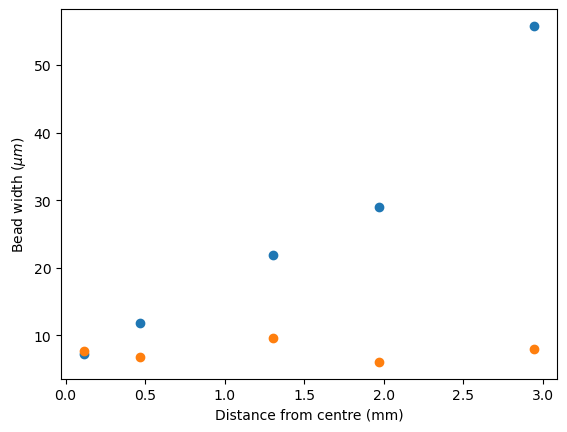

In [16]:
excel = pd.read_excel('../../OPT Shared files/2_Saved reconstructions/fd_focal scan/bead profiles.xlsx')
excel.head()

image_size = 1038
c = image_size //2
e = 6.45/1000 # pixel_size in mm

# extract these values from the excel file
x = excel.iloc[0].dropna().values[1:].astype(np.float64)
y = 2*c - excel.iloc[1].dropna().values[1:].astype(np.float64)
slice = excel.iloc[2].dropna().values[1:].astype(np.int16)

angles = np.arctan2((y-c), (x-c))*180/np.pi
r = np.sqrt((x-c)**2 + (y-c)**2)*e
print(r)
###

selected = [2,  4, 6, -2, -3]
dy = 50
fd_infocus = BeadDataset('../../OPT Shared files/2_Saved reconstructions/fd_focal scan/fd_infocus/reco')
fd_infocus.set_bead_locations(x[selected], y[selected], slice[selected])
# fd_infocus.set_bead_locations(x,y,slice)
_ = fd_infocus.get_rotated_slices()
fd_infocus.fit_all_beads()

plt.scatter(fd_infocus.r, fd_infocus.tangential_widths)
plt.scatter(fd_infocus.r, fd_infocus.radial_widths)

plt.ylabel('Bead width ($\mu m$)')
plt.xlabel('Distance from centre (mm)')

In [15]:
plt.imshow(fd_infocus.unrotated_slices[0])
fd_infocus.slice_numbers[0]
f_a = BeadDataset('../../OPT Shared files/2_Saved reconstructions/2023-03-01 aperture sweep/2023-03-01 f6/reco')

AttributeError: 'BeadDataset' object has no attribute 'unrotated_slices'

## Aperture scanning dataset

In [10]:
bead_positions = pd.read_excel('../../OPT Shared files/2_Saved reconstructions/2023-03-01 aperture sweep/bead_positions.xlsx')
x,y,slice = bead_positions[['x', 'y', 'slice']]

Old code

0595
122.27564431457763
0635
45.54565759341572
0752
76.4170364701633
1291
144.46232220802563
0378
-123.27160305309256


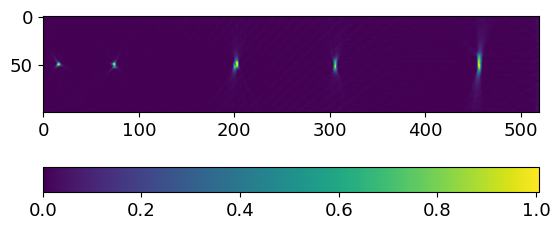

In [171]:
import matplotlib.pyplot as plt
padded_slice = [str(x).zfill(4) for x in slice]
dy = 50

final_image = np.zeros((image_size, image_size))
for i in selected:
    im = io.imread(f'../../OPT Shared files/2_Saved reconstructions/fd_focal scan/fd_infocus/reco{padded_slice[i]}.tif')
    
    rotated_image = rotate(im, -angles[i])
    final_image += rotated_image/ np.max(rotated_image[c-dy:c+dy, c:])
    print(padded_slice[i])
    print(angles[i])

plt.imshow(final_image[c-dy:c+dy:, c: ])
plt.colorbar(location='bottom')

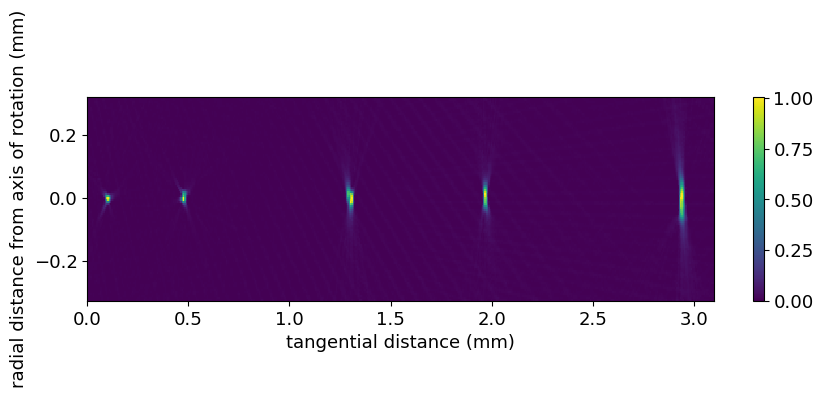

In [172]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(9,3))
x_grid = (np.arange(c, image_size) - c)*e
y_grid = np.arange(-dy, dy)*e
plt.pcolormesh(x_grid, y_grid, final_image[c-dy:c+dy:, c: ])
plt.ylabel('radial distance from axis of rotation (mm)')
plt.xlabel('tangential distance (mm)')
plt.colorbar(location='right')
plt.xlim(0, 3.1)
plt.tight_layout()

## Bead profiles

In [173]:
# Generate Gaussian profiles
def gaussian(x, sigma):
    return np.exp(-x**2/(2*sigma**2))

def top_hat(x):
    hat = np.zeros(len(x))
    hat[np.abs(x)<7.5] = 1
    return hat

from numpy.fft import fft, ifft, fftshift, fftfreq

freqs = np.arange(-200, 200)
profile = gaussian(freqs, 23)
profile_wide = gaussian(freqs, 80)

x = fftshift(fftfreq(len(freqs))) * 1000
psf_1 = fftshift(np.abs(fft(profile)))
psf_2 = fftshift(np.abs(fft(profile_wide)))
bead = 100*top_hat(x)

bead_transform = np.abs(fftshift(fft(bead)))
multiplied = bead_transform * profile
multiplied_2 = bead_transform * profile_wide

convolved = fftshift(np.abs(ifft(multiplied)))
convolved_2 = fftshift(np.abs(ifft(multiplied_2)))

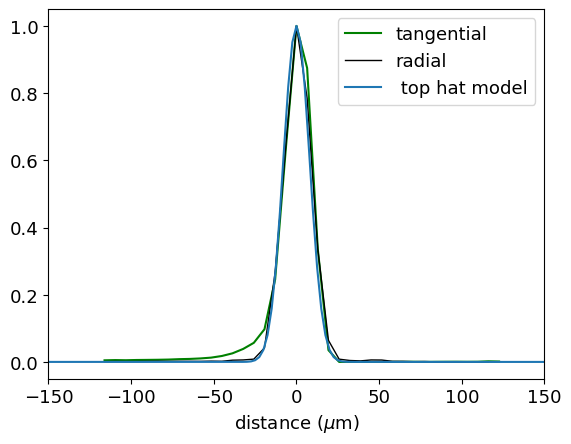

In [174]:
def range_from_profile(array):
    return (np.arange(0,len(array))-np.argmax(array)) * e*1000
# plt.rcParams.update({'font.size': 14})
# plt.figure(figsize=(5,4))
small_tangential = excel.iloc[:,4*11+2].dropna()
plt.plot(range_from_profile(small_tangential),  small_tangential/small_tangential.max(), 'g-', label='tangential', )
small_radial = excel.iloc[:,4*11+4].dropna()
plt.plot(range_from_profile(small_radial), small_radial/small_radial.max(), color='black', lw=1, label = 'radial')

plt.xlim(-150, 150)
plt.xlabel('distance ($\mu$m)')

plt.plot(x, convolved/convolved.max(), label=' top hat model')

plt.legend()


Text(0.5, 0, 'distance ($\\mu$m)')

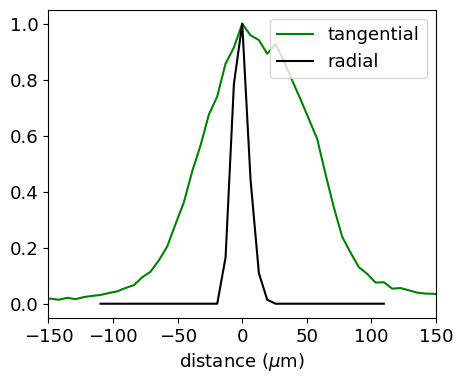

In [175]:
plt.figure(figsize=(5,4))
big_tangential = excel.iloc[:,10*4+2].dropna()
big_radial = excel.iloc[:,10*4+4].dropna()
plt.plot(range_from_profile(big_tangential), big_tangential/big_tangential.max(), 'g-', label='tangential')
plt.plot(range_from_profile(big_radial), big_radial/big_radial.max(), color='black', label='radial')
plt.legend(loc='upper right')
plt.xlim(-150, 150)
plt.xlabel('distance ($\mu$m)')

## Fitting bid widths

Data processing step of extracting bead profiles from the excel dataset. 

In [39]:
num_beads = (excel.shape[1] - 1)//4 
num_beads
from scipy.optimize import curve_fit

tangentials = [] 
radials = []
for i in range(num_beads):
    array = excel.iloc[:,i*4+2].dropna().values
    tangentials.append(array)
    radial = excel.iloc[:,i*4+4].dropna().values
    radials.append(radial)
    # plt.plot(tangentials[i])
    # plt.plot(radials[i])

In [40]:
def gaussian(x, mu, sigma, A):
    return A*np.exp(-((x-mu)**2/sigma**2 / 2))

In [41]:
p0 = [0, 50, 1]
popt, pcov = curve_fit(gaussian, range_from_profile(big_tangential), big_tangential/big_tangential.max(), p0=p0)

NameError: name 'big_tangential' is not defined

In [55]:
tangential_widths = []
tangential_width_errors = []
radial_widths = []

for i in range(num_beads):
    # tangential profiles
    array = tangentials[i]
    popt, pcov = curve_fit(gaussian, range_from_profile(array), array/array.max(), p0=p0)
    tangential_widths.append(popt[1])
    tangential_width_errors.append(np.sqrt(pcov[1,1]))
    # radial profiles
    array = radials[i]
    popt, pcov = curve_fit(gaussian, range_from_profile(array), array/array.max(), p0=p0)
    radial_widths.append(popt[1])

np.array(radial_widths)[selected]
[10.23266491425854,
 7.2668261313547475,
 6.276405239535683,
 8.188189516449492,
 7.7949117123053995]

array([12.76538752,  6.87725189,  5.74221944,  8.16265709,  6.16900745])

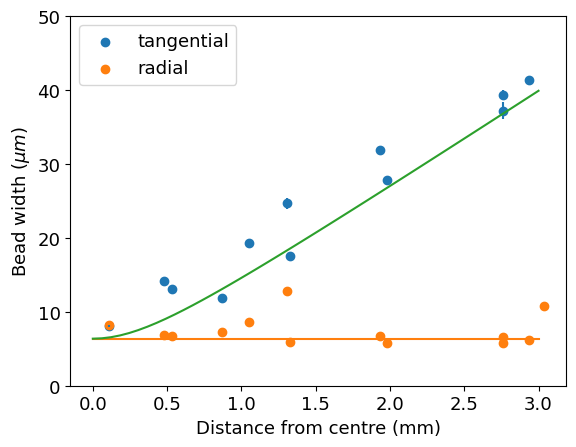

In [180]:
def theoretical_radial_width(w0):
    return np.sqrt(w0**2/2)

def theoretical_tangential_width(r0, w0,lamb):
    return np.sqrt((w0*w0 + (lamb*r0/(np.pi*w0))**2 )/2)

r0 = np.linspace(0,3) # mm
lamb = 525/1000 # um
w0 = 9

plt.errorbar(r, tangential_widths, yerr=tangential_width_errors, ls='')
plt.ylabel('Bead width ($\mu m$)')
plt.xlabel('Distance from centre (mm)')
plt.scatter(r, tangential_widths, label= 'tangential')
plt.scatter(r, radial_widths, label='radial')
plt.plot(r0, theoretical_radial_width(w0) + r0*0)

plt.plot(r0, theoretical_tangential_width(r0*1000, w0, lamb))
plt.ylim(0,50)
plt.legend()

[0.85168477 8.16265709 0.99447738]


(-30.0, 30.0)

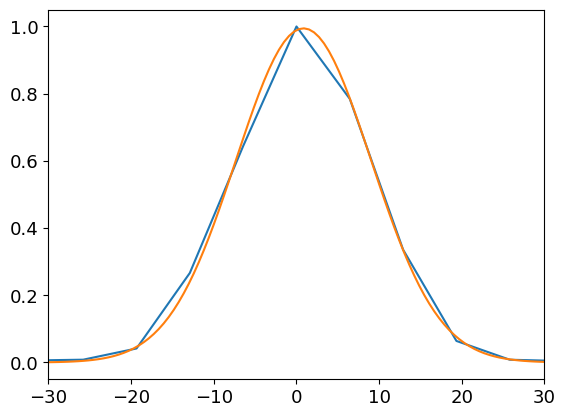

In [182]:
popt, pcov = curve_fit(gaussian, range_from_profile(small_radial), small_radial/small_radial.max(), p0=p0)
xs = range_from_profile(small_radial)
plt.plot(xs, small_radial/small_radial.max())
# plt.plot(xs, gaussian(xs, 0, 15, 1))
x_range = np.linspace(-30, 30, 100)
plt.plot(x_range, gaussian(x_range, *popt))
print(popt)
plt.xlim(-30, 30)

In [183]:
2.355*popt[1]

19.223057455199935

To get PSF width

In [184]:
np.sqrt((2.355*popt[1])**2 - 15**2)

12.021894107249398